In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder

## Load Cleaned Data

In [68]:
clean_df = pd.read_csv("D:/Sajid/Chrun_Prediction/data/processed/clean_data.csv")
print("Cleaned shape:", clean_df.shape)

Cleaned shape: (7032, 20)


## Feature Engeerning

In [69]:
# 1. Contract Type Indicator:

# Convert contract type into a binary indicator for long-term commitment
clean_df['is_long_term_contract'] = clean_df['Contract'].map({"Month-to-month": 0, "One year": 1, "Two year": 1})


# 2. Tenure Group
clean_df['tenure_group'] = pd.cut(
    clean_df['tenure'],
    bins=[0, 12, 24, 48, 60, 999],
    labels=["less_1yr", "1-2yrs", "2-4yrs", "4-5yrs", "5+yrs"]
)




# 3. Total Services Used
#### count of total servies that customer has
actual_service_cols = ['PhoneService', 'MultipleLines','OnlineSecurity', 'OnlineBackup',
                       'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']


# Replace no-internet/phone service with 'No' for consistency
clean_df['total_services'] = clean_df[actual_service_cols] \
    .replace(['No internet service', 'No phone service'], 'No') \
    .apply(lambda row: sum(row == 'Yes'), axis=1)


# 4. Has Internet Flag
### Binary feature if user has any form of internet connection
clean_df['has_internet'] = clean_df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)


# 5. Tech Dependent Score
# Count how many tech-related services are subscribed
tech_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]
clean_df['is_tech_dependent'] = clean_df[tech_cols] \
    .replace('No internet service', 'No') \
    .apply(lambda row: sum(row == 'Yes'), axis=1)


#6. Has Streaming Services
# Has Streaming Services (TV or Movies)
clean_df['has_streaming'] = clean_df[['StreamingTV', 'StreamingMovies']] \
    .replace(['No internet service'], 'No') \
    .apply(lambda row: int(any(row == 'Yes')), axis=1)

# 7. Has Bundle (Phone + Internet)
clean_df['has_bundle'] = clean_df.apply(lambda x: int(x['PhoneService'] == 'Yes' and x['InternetService'] != 'No'), axis=1)

# 8. Senior Citizen Living Alone
##### has senior citizen with no partner or dependent
clean_df['is_senior_alone'] = clean_df.apply(lambda x: int(x['SeniorCitizen'] == 1 and x['Partner'] == 'No' and x['Dependents'] == 'No'), axis=1)


# 9.  Low Tenure High Monthly Charge
clean_df['low_tenure_high_charge'] = ((clean_df['tenure'] < 6) & (clean_df['MonthlyCharges'] > 80)).astype(int)


##  Summary statistics

In [70]:
print("\nDescriptive Statistics:")
clean_df.describe()


Descriptive Statistics:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,is_long_term_contract,total_services,has_internet,is_tech_dependent,has_streaming,has_bundle,is_senior_alone,low_tenure_high_charge
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.448948,3.363339,0.783845,1.265358,0.497014,0.687144,0.079778,0.035836
std,0.368844,24.545260,30.085974,2266.771362,0.497422,2.062067,0.411650,1.286277,0.500027,0.463689,0.270969,0.185895
min,0.000000,1.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000,5.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000,8.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000


##   Encoding Categorical Features

- Encode Categorical Variables based on cardinality

In [71]:
cat_cols = clean_df.select_dtypes(include=['object', 'category']).columns
le = LabelEncoder()
binary_encoded_cols = []
onehot_encoded_cols = []
label_encoded_cols = []

for col in cat_cols:
    unique_vals = clean_df[col].nunique()

    if unique_vals == 2:
        clean_df[col] = clean_df[col].map({"Yes": 1, "No": 0}) if set(clean_df[col].unique()) == {"Yes", "No"} else le.fit_transform(clean_df[col])
        binary_encoded_cols.append(col)

    elif unique_vals <= 5:
        clean_df = pd.get_dummies(clean_df, columns=[col], drop_first=True)
        onehot_encoded_cols.append(col)

    else:
        clean_df[col] = le.fit_transform(clean_df[col])
        label_encoded_cols.append(col)


In [72]:
print("Final dataset shape after encoding:", clean_df.shape)

Final dataset shape after encoding: (7032, 43)


In [73]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 43 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7032 non-null   int32  
 1   SeniorCitizen                          7032 non-null   int64  
 2   Partner                                7032 non-null   int64  
 3   Dependents                             7032 non-null   int64  
 4   tenure                                 7032 non-null   int64  
 5   PhoneService                           7032 non-null   int64  
 6   PaperlessBilling                       7032 non-null   int64  
 7   MonthlyCharges                         7032 non-null   float64
 8   TotalCharges                           7032 non-null   float64
 9   Churn                                  7032 non-null   int64  
 10  is_long_term_contract                  7032 non-null   int64  
 11  tota

## Check corr between the features

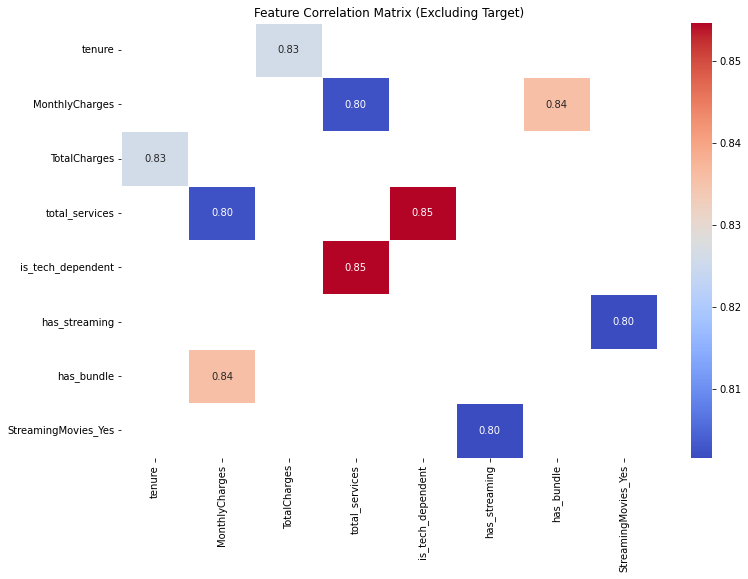

In [75]:
corr_matrix = clean_df.drop(columns=["Churn"]).corr()

# Select only highly correlated features (|correlation| > 0.6)
high_corr = corr_matrix[(corr_matrix.abs() > 0.80) & (corr_matrix.abs() < 1.0)]

# Drop rows/cols with all NaN values (i.e., features that don't have high correlation)
high_corr = high_corr.dropna(how='all').dropna(axis=1, how='all')


# Plot the correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(high_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix (Excluding Target)")
plt.show()

## Save Final Encoded Dataset

In [76]:
clean_df.to_csv("D:/Sajid/Chrun_Prediction/data/processed/final_encoded_data.csv", index=False)
print("Final encoded dataset saved as 'final_encoded_data.csv'")

Final encoded dataset saved as 'final_encoded_data.csv'
